In [1]:
# Imports
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy.stats import zscore
import shap


/home/mojo/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-16 14:28:58.795428: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 14:28:58.809781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742149738.825795    3049 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742149738.830656    3049 cuda_blas.cc:14

# Load data 

In [17]:
# Set the path to the file you'd like to load
file_path = "GlobalWeatherRepository.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "nelgiriyewithana/global-weather-repository",
  file_path
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

# print("First 5 records:", df.head())
df.head()

/tmp/ipykernel_3049/1065461630.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


### Check for missing values

In [18]:
missing_values = df.isnull().sum()

# drop unnecessary duplicate columns
df_cleaned = df.drop(columns=["temperature_fahrenheit", "wind_mph", "pressure_in", "precip_in", 
                              "feels_like_fahrenheit", "visibility_miles", "gust_mph"])


# Convert date column to datetime format
df_cleaned["last_updated"] = pd.to_datetime(df_cleaned["last_updated"])


# Exploratory data analysis

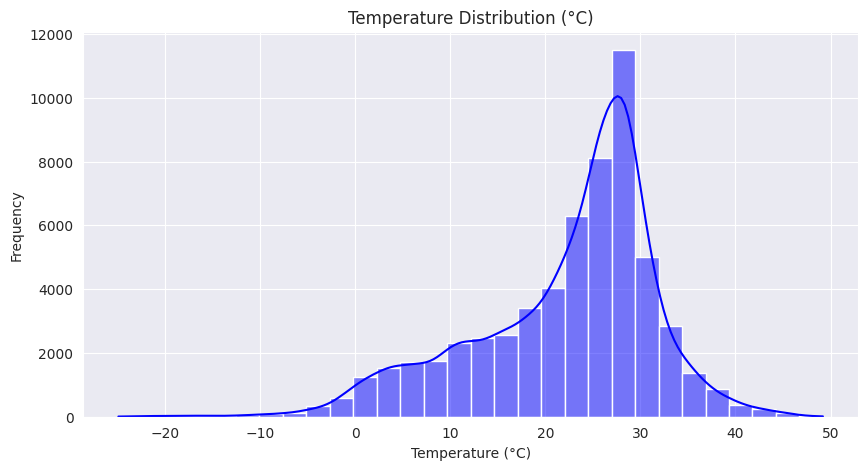

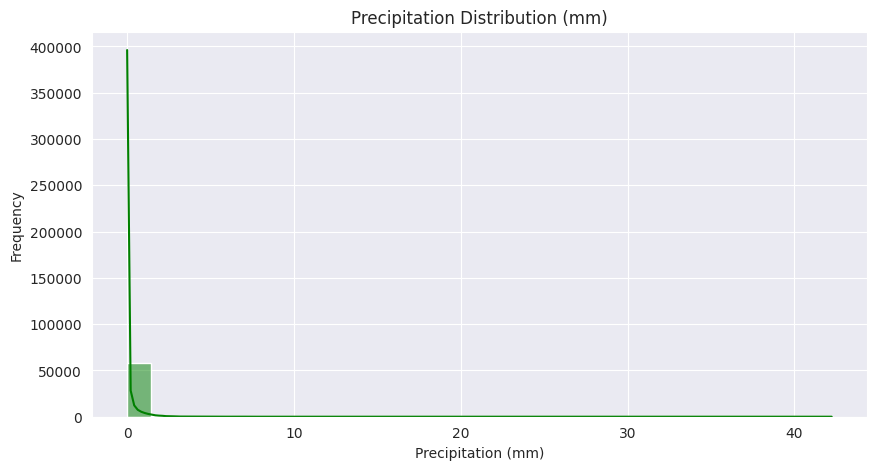

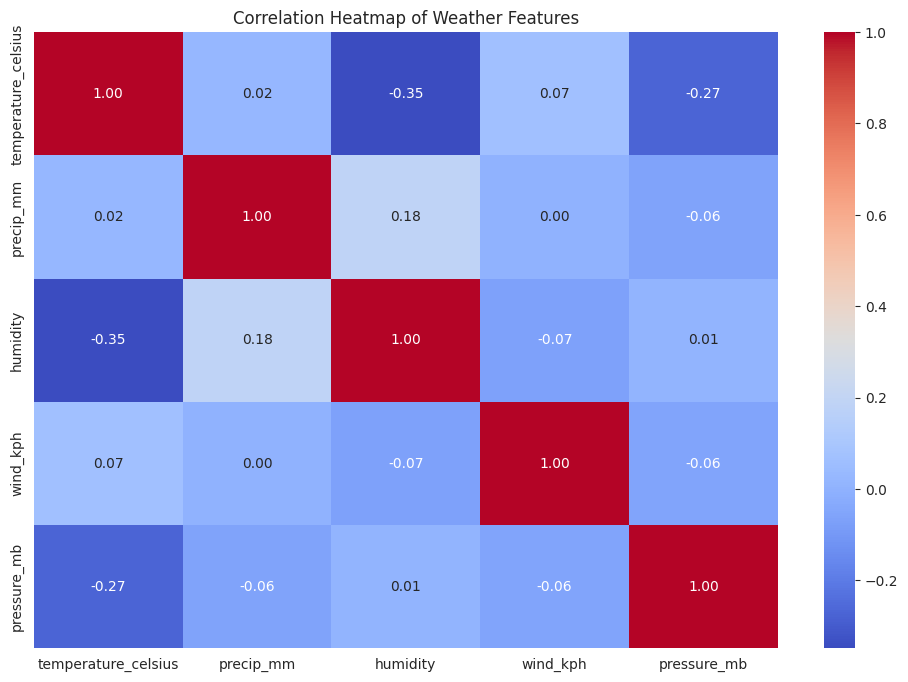

In [19]:
# Set style
sns.set_style("darkgrid")

# Plot temperature distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned["temperature_celsius"], bins=30, kde=True, color="blue")
plt.title("Temperature Distribution (°C)")
plt.xlabel("Temperature (°C)")
plt.ylabel("Frequency")
plt.show()

# Plot precipitation distribution
plt.figure(figsize=(10, 5))
sns.histplot(df_cleaned["precip_mm"], bins=30, kde=True, color="green")
plt.title("Precipitation Distribution (mm)")
plt.xlabel("Precipitation (mm)")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap for key weather parameters
plt.figure(figsize=(12, 8))
correlation_matrix = df_cleaned[["temperature_celsius", "precip_mm", "humidity", "wind_kph", "pressure_mb"]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Weather Features")
plt.show()


## EDA Insights:
# Temperature Distribution:
* Most temperatures are within a reasonable range, with a peak around 20-30°C.
* Some extreme values might indicate anomalies.

## Precipitation Distribution:
* Most areas have low precipitation, but a few locations experience heavy rainfall.

## Correlation Heatmap:
* Temperature and Humidity: Negative correlation (warmer regions tend to be less humid).
* Wind Speed and Pressure: Weak correlation, but worth exploring further.
* Precipitation and Humidity: Positive correlation (rainy conditions are usually humid)

# Model Building

# ARIMA Model

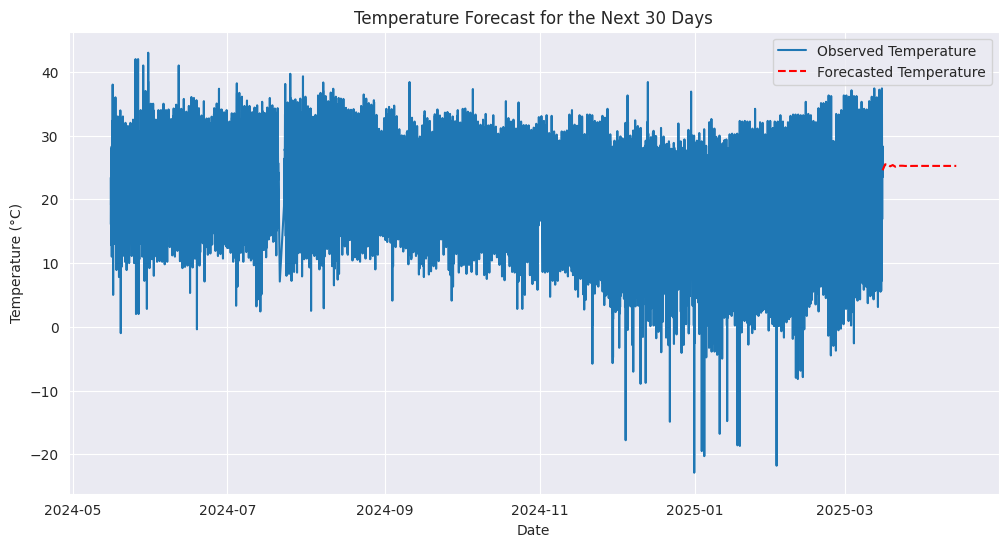

In [6]:


# Prepare time series data (aggregating global temperature over time)
df_time_series = df_cleaned.groupby("last_updated")["temperature_celsius"].mean().reset_index()

# Sort by date
df_time_series = df_time_series.sort_values("last_updated")

# Train an ARIMA model for forecasting
model = ARIMA(df_time_series["temperature_celsius"], order=(5,1,0))  # ARIMA(5,1,0) chosen arbitrarily
model_fit = model.fit()

# Forecast next 30 days
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates
future_dates = pd.date_range(start=df_time_series["last_updated"].max(), periods=forecast_steps, freq="D")

# Plot forecast
plt.figure(figsize=(12, 6))
plt.plot(df_time_series["last_updated"], df_time_series["temperature_celsius"], label="Observed Temperature")
plt.plot(future_dates, forecast, label="Forecasted Temperature", linestyle="dashed", color="red")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Temperature Forecast for the Next 30 Days")
plt.legend()
plt.show()


In [7]:

# Splitting the data into training and testing sets (80% train, 20% test)
train_size = int(len(df_time_series) * 0.8)
train, test = df_time_series[:train_size], df_time_series[train_size:]

# Train ARIMA on training data
model = ARIMA(train["temperature_celsius"], order=(5,1,0))
model_fit = model.fit()

# Predict on test data
test_forecast = model_fit.forecast(steps=len(test))

# Calculate evaluation metrics
mae = mean_absolute_error(test["temperature_celsius"], test_forecast)
rmse = np.sqrt(mean_squared_error(test["temperature_celsius"], test_forecast))

print(f"Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Model Performance:
Mean Absolute Error (MAE): 6.48
Root Mean Squared Error (RMSE): 8.58


# Using Seasonal Arima

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(train["temperature_celsius"], order=(5,1,0), seasonal_order=(1,1,1,12))
sarima_fit = sarima_model.fit()

# Predict on test set
sarima_forecast = sarima_fit.forecast(steps=len(test))

# Evaluate
mae_sarima = mean_absolute_error(test["temperature_celsius"], sarima_forecast)
rmse_sarima = np.sqrt(mean_squared_error(test["temperature_celsius"], sarima_forecast))

print(f"SARIMA Performance: MAE = {mae_sarima:.2f}, RMSE = {rmse_sarima:.2f}")


SARIMA Performance: MAE = 6.58, RMSE = 8.71


# LSTM Model

In [9]:
# Convert last_updated to datetime and sort by date
df["last_updated"] = pd.to_datetime(df["last_updated"])
df = df.sort_values("last_updated")

# Select temperature as target variable
data = df[["last_updated", "temperature_celsius"]].dropna()

# Normalize temperature data
scaler = MinMaxScaler(feature_range=(0,1))
data["temperature_celsius"] = scaler.fit_transform(data[["temperature_celsius"]])

# Convert to numpy array
temperature_data = data["temperature_celsius"].values


In [10]:
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Last 30 days
        y.append(data[i+seq_length])    # Next day's temperature
    return np.array(X), np.array(y)

seq_length = 30  # Use past 30 days to predict next day
X, y = create_sequences(temperature_data, seq_length)

# Reshape X for LSTM input (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [11]:
# tf.config.set_visible_devices([], 'GPU')  # Disable GPU

# Define LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),  # First LSTM layer
    Dropout(0.2),  
    LSTM(50, return_sequences=False),  # Second LSTM layer
    Dropout(0.2),
    Dense(25),  # Fully connected layer
    Dense(1)  # Output layer (predict temperature)
])

# Compile model
model.compile(optimizer="adam", loss="mean_squared_error")

# Train the model
history = model.fit(X, y, epochs=30, batch_size=16, validation_split=0.2)
model.save("lstm_temperature_forecast.h5")


I0000 00:00:1742068911.473240     714 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5520 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/mojo/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30


I0000 00:00:1742068913.534979    1500 cuda_dnn.cc:529] Loaded cuDNN version 90300


2942/2942 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - loss: 0.0161 - val_loss: 0.0225
Epoch 2/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0124 - val_loss: 0.0220
Epoch 3/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0123 - val_loss: 0.0214
Epoch 4/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0122 - val_loss: 0.0213
Epoch 5/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 0.0124 - val_loss: 0.0215
Epoch 6/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0122 - val_loss: 0.0220
Epoch 7/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - loss: 0.0122 - val_loss: 0.0214
Epoch 8/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0123 - val_loss: 0.0214
Epoch 9/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0121 - val_loss: 0.0213
Epoch 10/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 44s 15ms/step - loss: 0.0122 - val_loss: 0.0212
Epoch 11/30
2942/2942 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.0123 - val_loss: 0.0208
Epoch 12/30
2942/29

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━

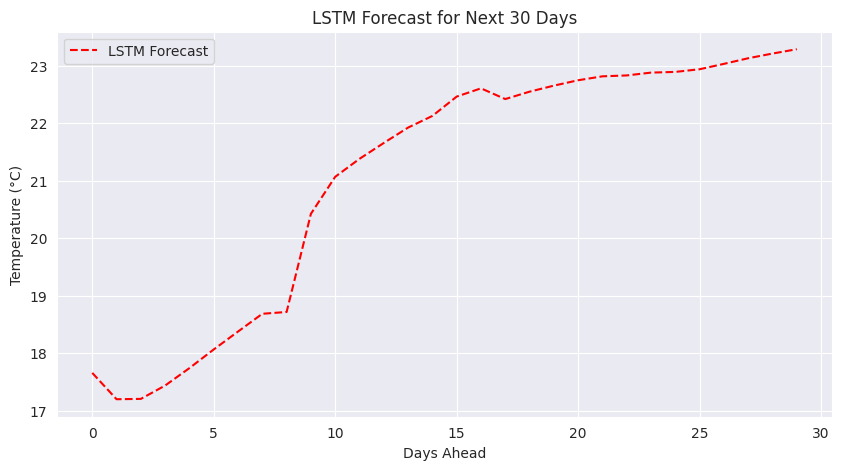

In [12]:
# Predict next 30 days
last_30_days = temperature_data[-seq_length:].reshape(1, seq_length, 1)  # Reshape for LSTM
predictions = []

for _ in range(30):  
    pred = model.predict(last_30_days)[0][0]  # Predict next day
    predictions.append(pred)
    
    # Update input sequence
    last_30_days = np.roll(last_30_days, -1)
    last_30_days[0, -1, 0] = pred

# Convert predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


# Plot results
plt.figure(figsize=(10,5))
plt.plot(predictions, label="LSTM Forecast", linestyle="dashed", color="red")
plt.xlabel("Days Ahead")
plt.ylabel("Temperature (°C)")
plt.title("LSTM Forecast for Next 30 Days")
plt.legend()
plt.show()


In [13]:
y_pred = model.predict(X)
y_pred = scaler.inverse_transform(y_pred)  # Convert back to original scale
y_actual = scaler.inverse_transform(y.reshape(-1, 1))  # Convert actual values back

# Calculate MAE and RMSE
mae = mean_absolute_error(y_actual, y_pred)
rmse = np.sqrt(mean_squared_error(y_actual, y_pred))

print(f"LSTM Model Performance:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


1839/1839 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step
LSTM Model Performance:
Mean Absolute Error (MAE): 6.68
Root Mean Squared Error (RMSE): 8.63


# Anomaly detection

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [15]:
df.columns

Index(['country', 'location_name', 'latitude', 'longitude', 'timezone',
       'last_updated_epoch', 'last_updated', 'temperature_celsius',
       'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph',
       'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in',
       'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius',
       'feels_like_fahrenheit', 'visibility_km', 'visibility_miles',
       'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide',
       'air_quality_Ozone', 'air_quality_Nitrogen_dioxide',
       'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10',
       'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise',
       'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination'],
      dtype='object')

# Isolation forest

In [16]:
df["last_updated"] = pd.to_datetime(df["last_updated"])
df = df.sort_values("last_updated")

# Select relevant columns for anomaly detection
features = ["temperature_celsius", "humidity", "wind_mph", "precip_mm"]
df_filtered = df[features].dropna()


# Train Isolation Forest
iso_forest = IsolationForest(contamination=0.02, random_state=42)
df_filtered["anomaly_score"] = iso_forest.fit_predict(df_filtered)

# Extract anomalies
anomalies_iforest = df_filtered[df_filtered["anomaly_score"] == -1]

print(f"Total anomalies detected using Isolation Forest: {len(anomalies_iforest)}")


Total anomalies detected using Isolation Forest: 1178


# Z-Score Method (Statistical Anomaly Detection)

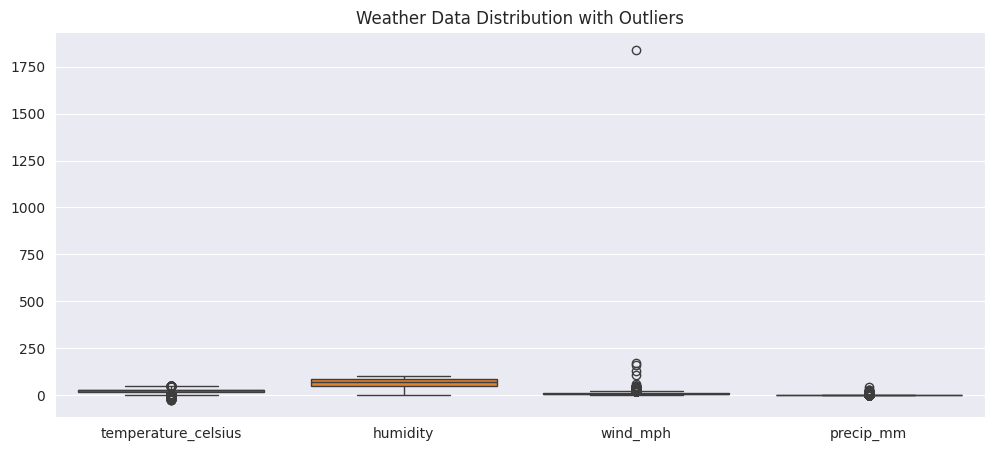

Total anomalies detected using Z-Score: 1091


In [17]:
# Convert last_updated to datetime and sort by date
df["last_updated"] = pd.to_datetime(df["last_updated"])
df = df.sort_values("last_updated")

# Select relevant columns for anomaly detection
features = ["temperature_celsius", "humidity", "wind_mph", "precip_mm"]
df_filtered = df[features].dropna()


# Compute Z-score
z_scores = np.abs(zscore(df_filtered))

# Identify anomalies (Z-score > 3)
anomalies_zscore = df_filtered[(z_scores > 3).any(axis=1)]

# Visualize anomalies
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_filtered)
plt.title("Weather Data Distribution with Outliers")
plt.show()

print(f"Total anomalies detected using Z-Score: {len(anomalies_zscore)}")


In [18]:
# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_filtered.drop(columns=["anomaly_score"], errors="ignore"))

# Define Autoencoder
model = Sequential([
    Dense(16, activation="relu", input_shape=(df_scaled.shape[1],)),
    Dropout(0.2),
    Dense(8, activation="relu"),
    Dense(16, activation="relu"),
    Dense(df_scaled.shape[1], activation="linear")  # Reconstruct input
])

# Compile & train model
model.compile(optimizer="adam", loss="mse")
model.fit(df_scaled, df_scaled, epochs=20, batch_size=16, validation_split=0.2, verbose=0)

# Compute reconstruction error
reconstructed = model.predict(df_scaled)
errors = np.mean(np.abs(df_scaled - reconstructed), axis=1)

# Identify anomalies (Threshold: Top 2% highest errors)
threshold = np.percentile(errors, 98)
anomalies_autoencoder = df_filtered[errors > threshold]

print(f"Total anomalies detected using Autoencoder: {len(anomalies_autoencoder)}")


/home/mojo/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1742070215.621368    1499 service.cc:152] XLA service 0x13d39e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1742070215.621462    1499 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-03-15 16:23:35.651957: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742070216.892838    1499 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process

1840/1840 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Total anomalies detected using Autoencoder: 1176


In [19]:
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [20]:

# Sample a subset of the data (e.g., 5000 rows)
df_sample = df_cleaned.sample(n=5000, random_state=42)

# Define features and target
X_sample = df_sample[["precip_mm", "humidity", "wind_kph", "pressure_mb"]]
y_sample = df_sample["temperature_celsius"]

# Split into training and testing sets
train_size = int(len(X_sample) * 0.8)
X_train_sample, X_test_sample = X_sample[:train_size], X_sample[train_size:]
y_train_sample, y_test_sample = y_sample[:train_size], y_sample[train_size:]

# Train RandomForest model
rf_model_sample = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_sample.fit(X_train_sample, y_train_sample)

# Predict on test set
y_pred_sample = rf_model_sample.predict(X_test_sample)

# Evaluate performance
mae_sample = mean_absolute_error(y_test_sample, y_pred_sample)
rmse_sample = np.sqrt(mean_squared_error(y_test_sample, y_pred_sample))

print(f"Random Forest Performance on Sampled Data: MAE = {mae_sample:.2f}, RMSE = {rmse_sample:.2f}")


Random Forest Performance on Sampled Data: MAE = 4.57, RMSE = 6.33


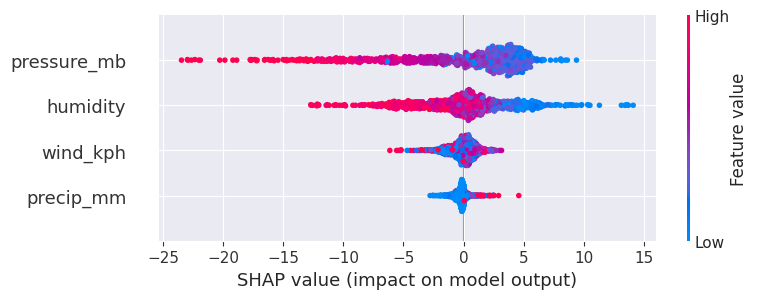

In [21]:
# Create SHAP explainer
explainer_sample = shap.TreeExplainer(rf_model_sample)

# Compute SHAP values only on a small test set (e.g., 1000 samples)
X_test_small = X_test_sample.sample(n=1000, random_state=42)
shap_values_sample = explainer_sample.shap_values(X_test_small)

# Summary plot of feature importance
shap.summary_plot(shap_values_sample, X_test_small)


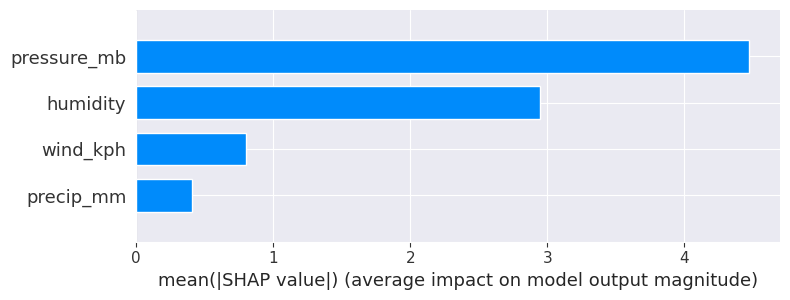

In [22]:
# Feature importance as a bar chart
shap.summary_plot(shap_values_sample, X_test_small, plot_type="bar")


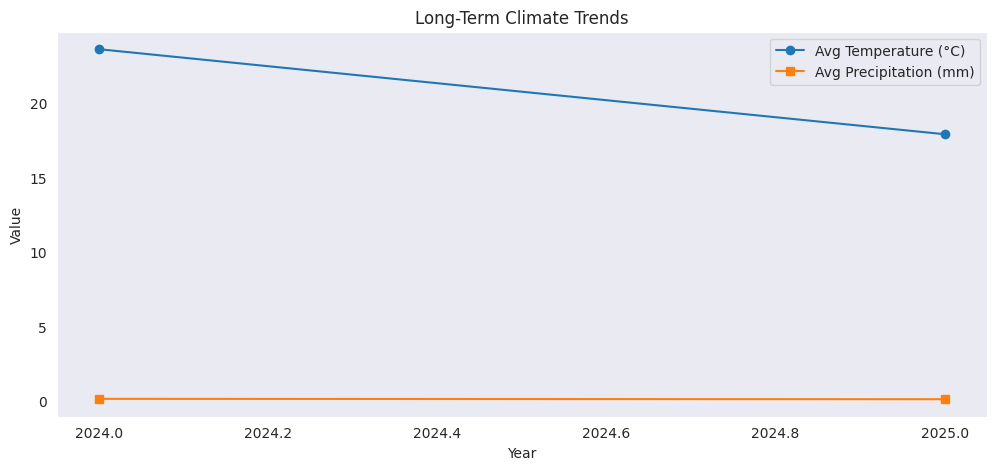

In [10]:
# Imports
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scipy.stats import zscore
import shap




# Climate Analysis: Studying Long-term Climate Patterns

import matplotlib.pyplot as plt

# Convert last_updated column to datetime if necessary
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Aggregate by year to study long-term trends
df['year'] = df['last_updated'].dt.year
climate_trends = df.groupby('year')[['temperature_celsius', 'precip_mm']].mean()

# Plot long-term trends
plt.figure(figsize=(12, 5))
plt.plot(climate_trends.index, climate_trends['temperature_celsius'], label='Avg Temperature (°C)', marker='o')
plt.plot(climate_trends.index, climate_trends['precip_mm'], label='Avg Precipitation (mm)', marker='s')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Long-Term Climate Trends')
plt.legend()
plt.grid()
plt.show()



Index(['country', 'temperature_celsius', 'precip_mm'], dtype='object')


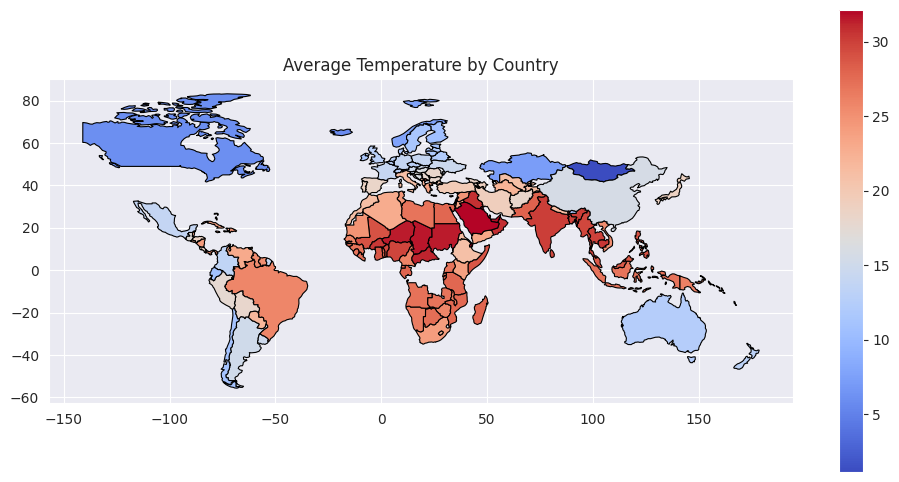

In [26]:
import geopandas as gpd
import contextily as ctx

# Load world map from Natural Earth dataset
world = gpd.read_file("https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip")

# for item in world.columns:
#     print(item)

# Aggregate weather data by country
country_weather = df_cleaned.groupby('country')[['temperature_celsius', 'precip_mm']].mean().reset_index()
print(country_weather.columns)

# Merge with world map data
world = world.merge(country_weather, left_on="NAME_LONG", right_on="country", how="left")

# Plot temperature distribution
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
world.plot(column='temperature_celsius', cmap='coolwarm', linewidth=0.8, edgecolor='black', legend=True, ax=ax)
plt.title('Average Temperature by Country')
plt.show()